# (2 of 2) Regression
---
# AirBnB
# Regression: Linear Regression, SVR
---

In [1]:
import sys
sys.version

'3.8.8 (default, Apr 13 2021, 19:58:26) \n[GCC 7.3.0]'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
df = pd.read_csv('./dataset/listings.csv',
                 usecols=['neighbourhood_group_cleansed',
                          'room_type','accommodates',
                          'bathrooms_text','beds','price',
                          'minimum_nights','maximum_nights',
                         ])

In [4]:
df['bathrooms_text'].replace('Half-bath','0.5 baths', inplace=True)
df['bathrooms_text'].replace('Shared half-bath','0.5 shared baths', inplace=True)
df['bathrooms_text'].replace('Private half-bath','0.5 baths', inplace=True)

In [5]:
df.dropna(subset=['bathrooms_text'], inplace=True)

In [6]:
df['baths'] = df['bathrooms_text'].apply(lambda x: x.split(' ')[0])

In [7]:
# list comprehension
df['shared-baths'] = [1 if x=='shared' else 0 \
                      for x in df['bathrooms_text'].apply(lambda x: x.split(' ')[1])]

In [8]:
df.drop(['bathrooms_text'],axis=1,inplace=True)

In [9]:
df['beds'].fillna(value=1, inplace=True)

In [10]:
df['baths'] = df['baths'].astype(float)
df['beds'] = df['beds'].astype(int)

df['shared-baths'] = df['shared-baths'].astype('category')

In [11]:
# Remove dollar and comma signs from price column
df['price'].replace({'\$':'', ',':''}, regex = True, inplace=True)

# Convert string to float
df['price'] = df['price'].astype(float)

## Outlier Manipulation

ถ้าไม่กำจัด โมเดลจะทำนายได้แย่มาก เพราะ algorithm มีความ sensitive ต่อ outlier ค่อนข้างมาก

ทำการ drop rows ที่มีค่าเกิน lower/upper fence

In [12]:
df_real = df.copy()

In [13]:
import plotly.express as px

px.box(df_real, y='price', x='neighbourhood_group_cleansed')

![](./img/img1.png) 

In [14]:
def my_func(a, b, c, val):
    tmp = df_real[(df_real[a]==b) & (df_real[c] >= val)]
    print('Dropping', tmp.shape[0], 'of', df_real.shape[0], 'rows.')
    df_real.drop(index=tmp.index, inplace=True)

In [15]:
my_func('neighbourhood_group_cleansed','Manhattan','price',319)
my_func('neighbourhood_group_cleansed','Brooklyn','price',263)
my_func('neighbourhood_group_cleansed','Queens','price',178)
my_func('neighbourhood_group_cleansed','Staten Island','price',195)
my_func('neighbourhood_group_cleansed','Bronx','price',175)

Dropping 2161 of 37535 rows.
Dropping 1162 of 35374 rows.
Dropping 689 of 34212 rows.
Dropping 36 of 33523 rows.
Dropping 126 of 33487 rows.


In [16]:
px.box(df_real, y='price', x='room_type')

![](./img/img2.png) 

In [17]:
my_func('room_type','Entire home/apt','price',303)
my_func('room_type','Private room','price',129)
my_func('room_type','Hotel room','price',402)
my_func('room_type','Shared room','price',125)

Dropping 130 of 33361 rows.
Dropping 1781 of 33231 rows.
Dropping 0 of 31450 rows.
Dropping 48 of 31450 rows.


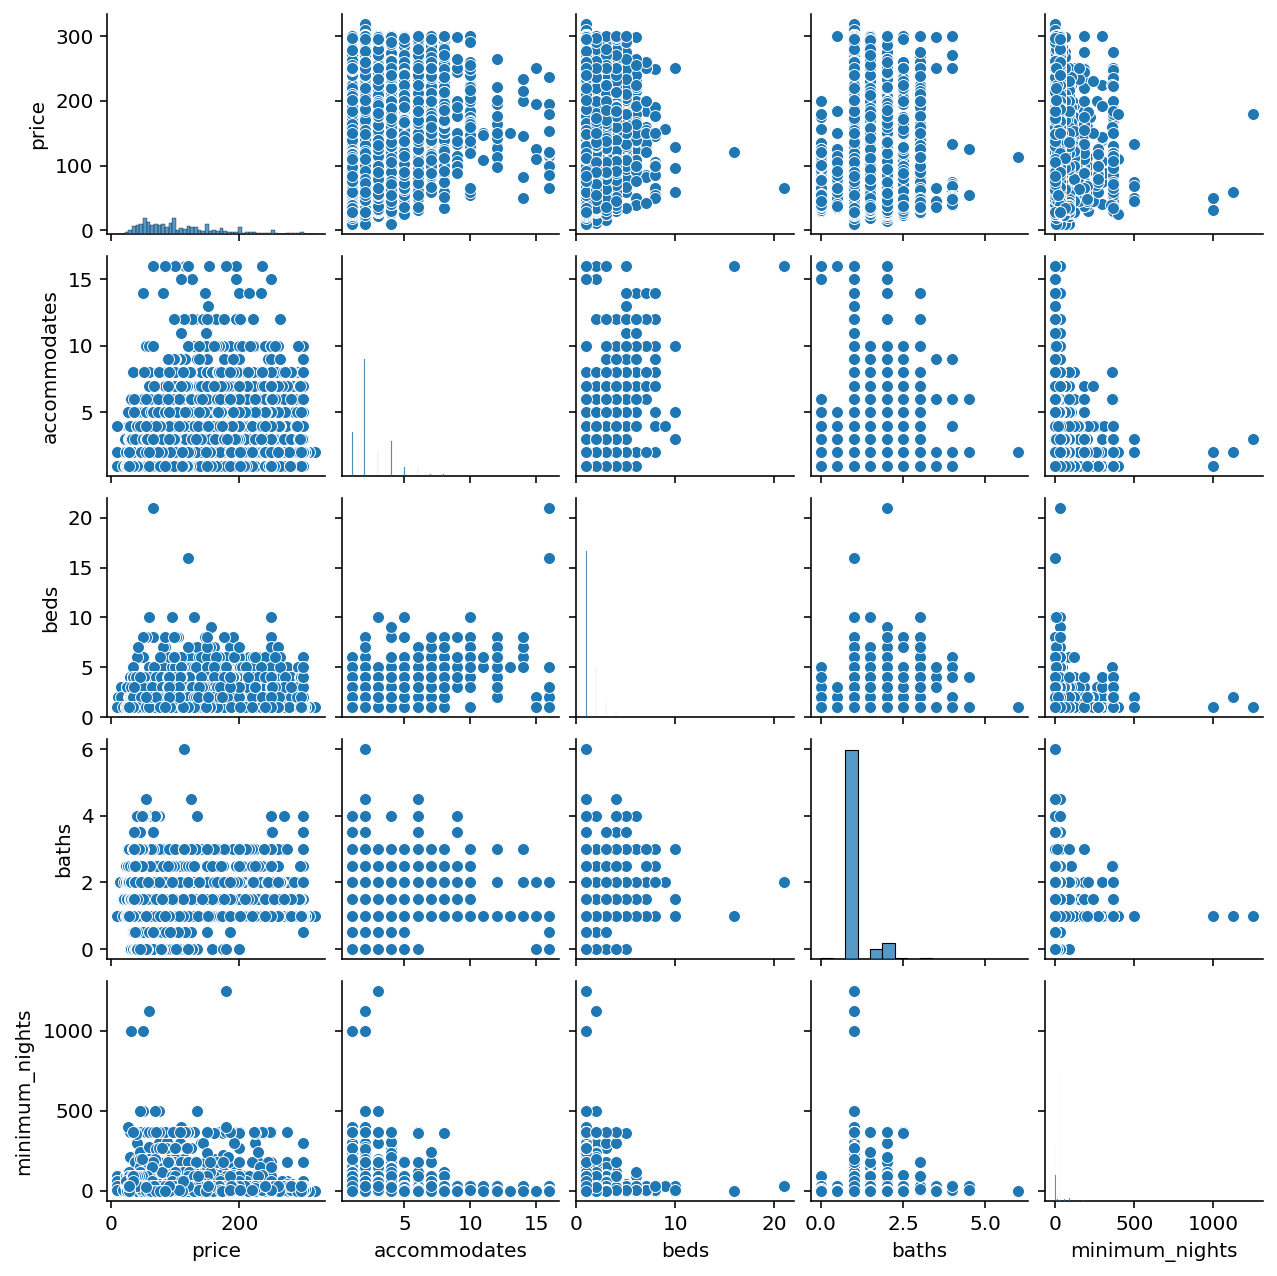

In [18]:
sns.pairplot(df_real[['price','accommodates','beds',
                      'baths','minimum_nights']], height=1.8)
plt.show()

หลังจาก drop outliers แล้วก็ยังแปลผลเหมือนเดิม  
- ห้องที่มีเตียงเยอะ มีแนวโน้มที่จะมีห้องอาบน้ำเยอะ  
- ห้องราคาสูง หรือ ห้องที่มีห้องอาบน้ำ หรือ เตียงเยอะ หรือ ห้องที่รองรับแขกได้มาก จะไม่มีการกำหนดจำนวนคืนขั้นต่ำไว้สูง
- ห้องราคาต่ำ หรือ ห้องที่มีห้องอาบน้ำ หรือ เตียงน้อย หรือ ห้องที่รองรับแขกได้น้อย จะมีบางห้องที่กำหนดจำนวนคืนขั้นต่ำสูงๆ รวมอยู่ด้วย

ยกเว้นแต่ที่ห้องราคาสูงจะไม่สามารถแปลผลว่า มีแนวโน้มจะรองรับแขกได้น้อย หรือ มีห้องอาบน้ำน้อย หรือ เตียงน้อย ได้แล้ว แสดงว่าผลพวกนี้เป็นสับเซตของ outliers

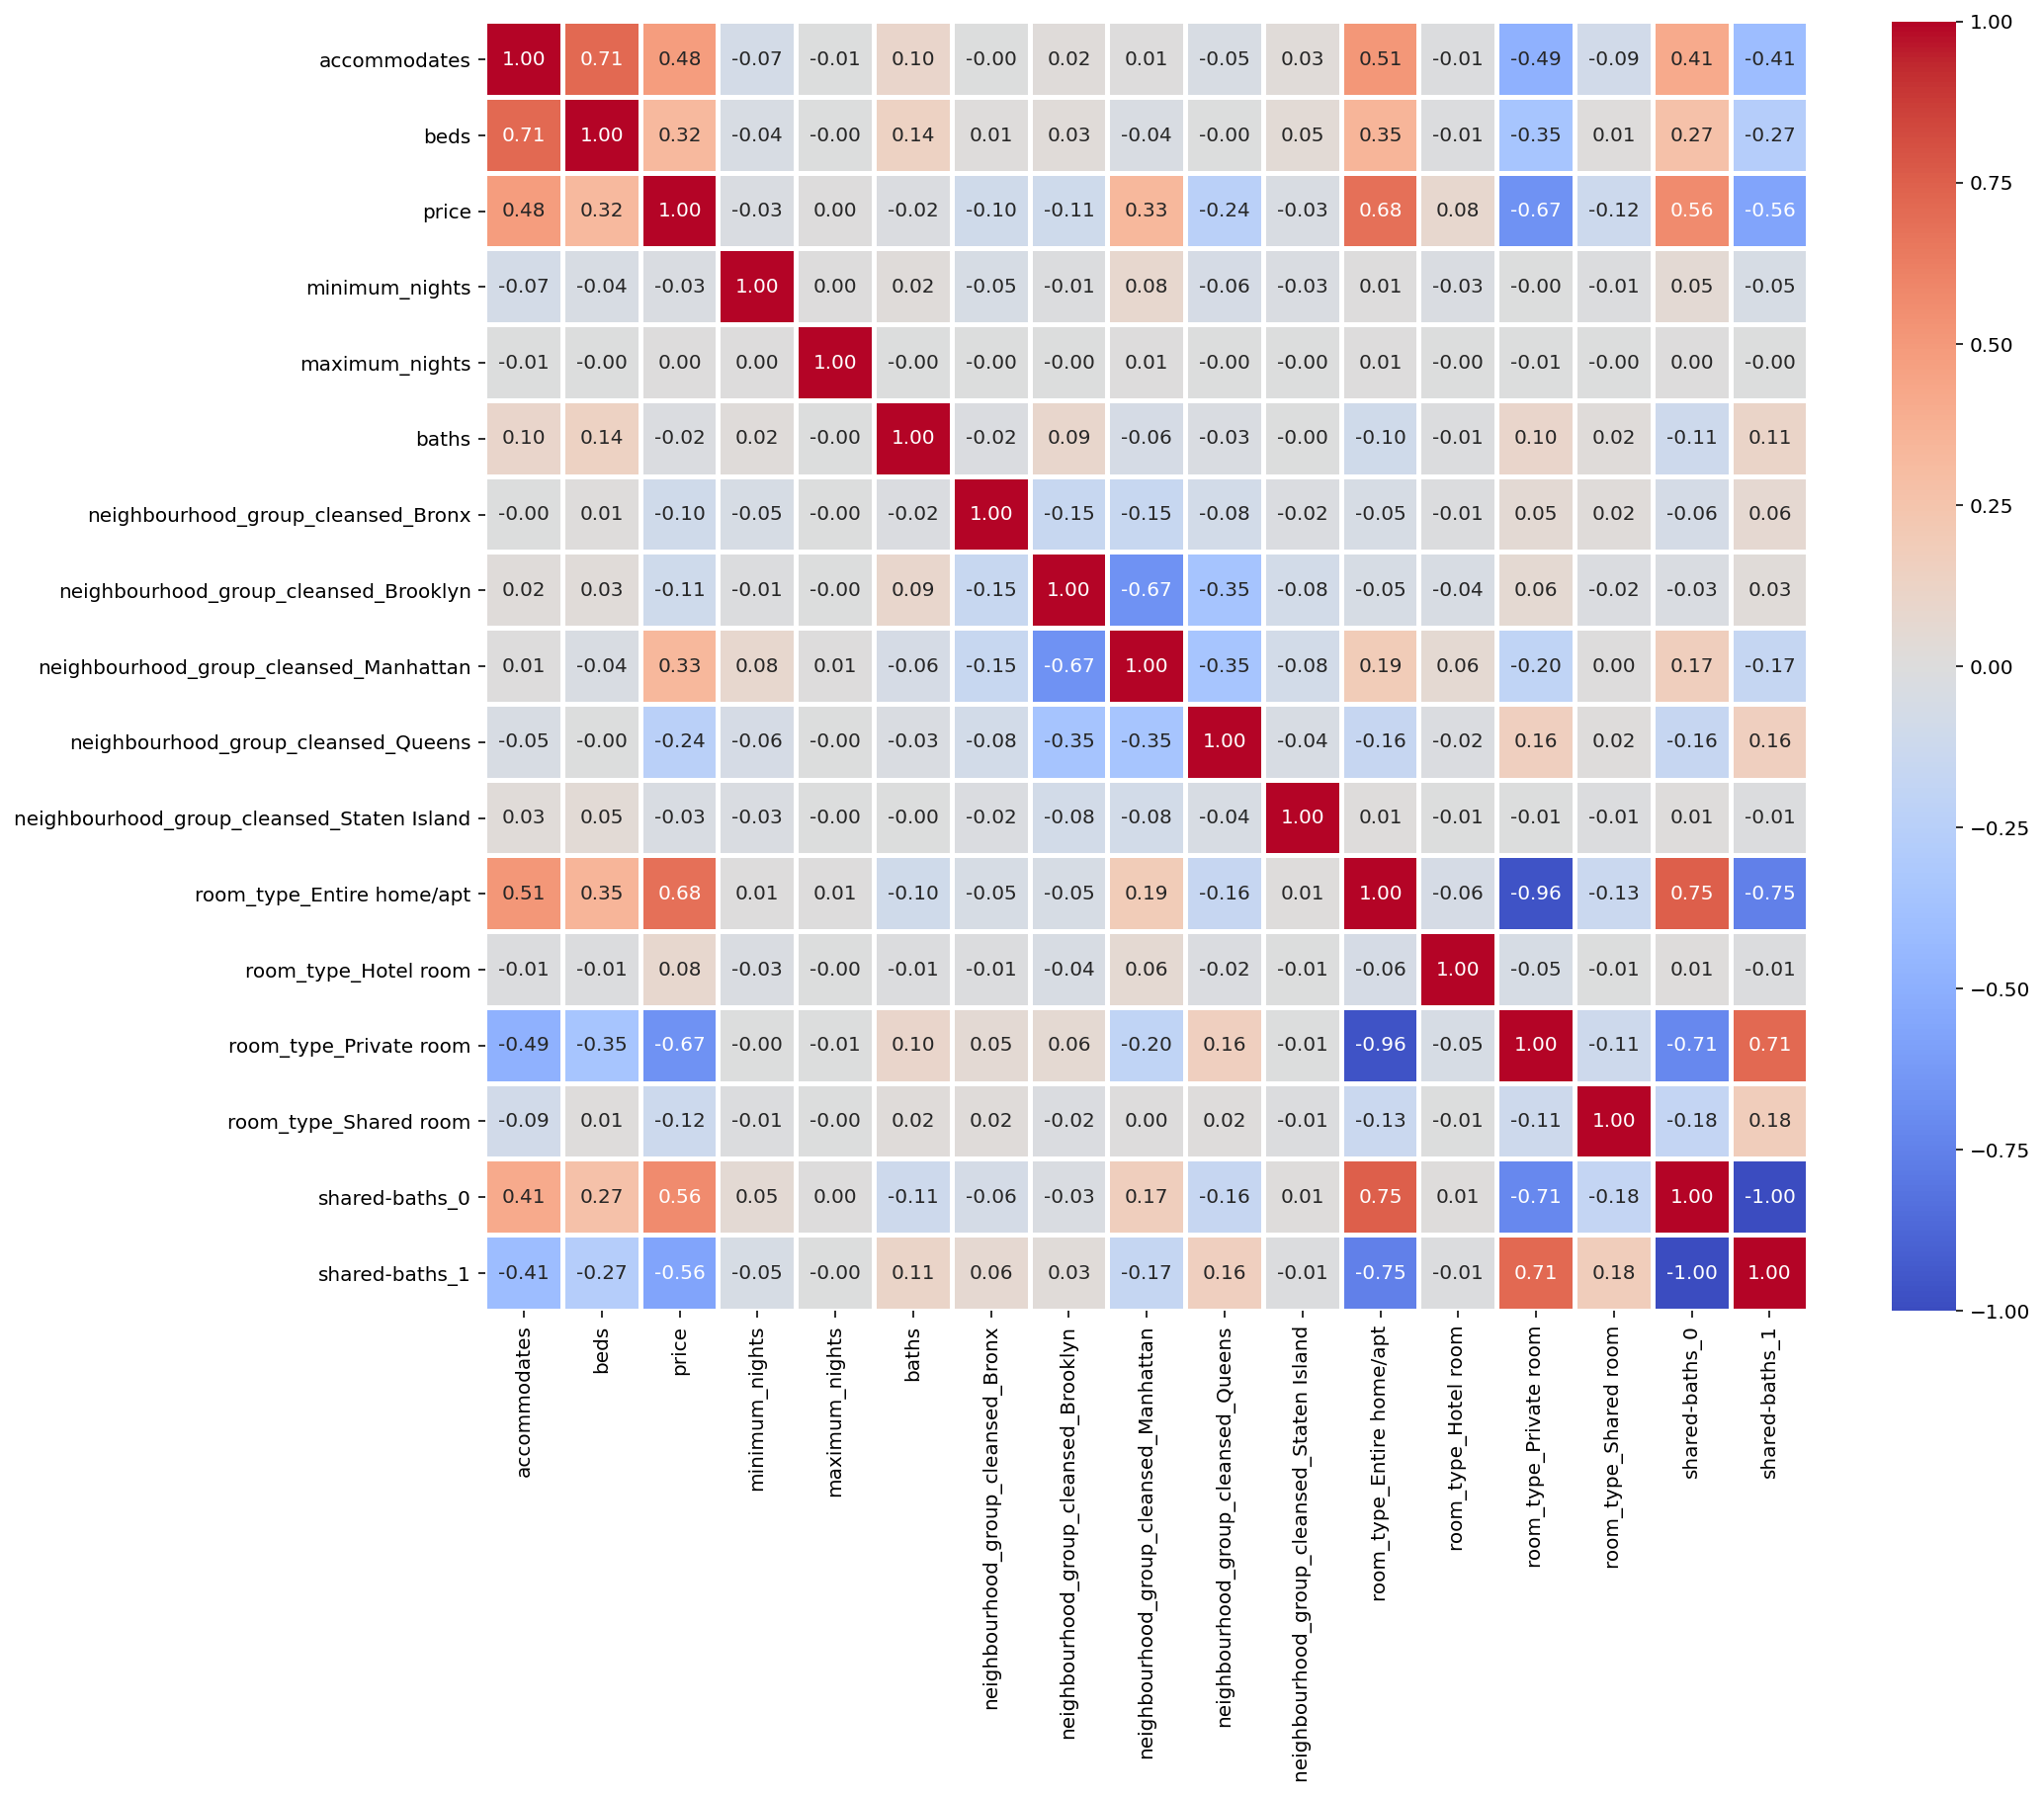

In [19]:
df_test = pd.get_dummies(df_real, drop_first=False)

fig = plt.figure(figsize=(15,12))
sns.heatmap(df_test.corr(), annot=True, fmt='.2f',
            cmap='coolwarm', linecolor='white', linewidths=2)
plt.show()

บาง features ที่ไม่ค่อย correlated กับ features ใดๆ ก็ไม่ควรนำมา train เพราะค่ามัน fluctuate อาจทำให้โมเดลแย่ลง คือ minimum_nights, maximum_nights

In [20]:
df_real.drop([
    'minimum_nights',
    'maximum_nights',
],axis=1, inplace=True)

### สร้าง dummy variables
drop_first=True เพื่อไม่ให้เป็น Multi-collinearity

In [21]:
df_real = pd.get_dummies(df_real, drop_first=True)

In [22]:
df_real.sample(5)

accommodates  beds  price  baths  \
23582             4     3   99.0    1.0   
15537             2     1   90.0    1.0   
1747              5     3   98.0    1.0   
13484             1     1   36.0    1.0   
36889             2     1   80.0    1.0   

       neighbourhood_group_cleansed_Brooklyn  \
23582                                      0   
15537                                      1   
1747                                       1   
13484                                      1   
36889                                      1   

       neighbourhood_group_cleansed_Manhattan  \
23582                                       1   
15537                                       0   
1747                                        0   
13484                                       0   
36889                                       0   

       neighbourhood_group_cleansed_Queens  \
23582                                    0   
15537                                    0   
1747                                     0   
13484                                    0   
36889                                    0   

       neighbourhood_group_cleansed_Staten Island  room_type_Hotel room  \
23582                                           0                     0   
15537                                           0                     0   
1747                                            0                     0   
13484                                           0                     0   
36889                                           0                     0   

       room_type_Private room  room_type_Shared room  shared-baths_1  
23582                       0                      0               0  
15537                       1                      0               1  
1747                        0                      0               0  
13484                       1                      0               1  
36889                       1                      0               1

In [23]:
X = df_real.drop(['price'], axis=1)

y = np.array(df_real['price']).reshape(-1,1)
# We need to reshape a serie into 1 column array
# before we feed it to the algorithm

### train/test split ด้วย 80:20 ratio

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(25121, 11)
(6281, 11)
(25121, 1)
(6281, 1)


---
# 1. Multiple Linear Regression
---

Linerar Regression ไม่จำเป็นต้องทำ Standard Scaler เพราะใช้การปรับเส้น regression  

แต่ SVR ควรทำ เพราะถ้า data points ของแต่ละ feature มี scale ต่างกันเกินไป จะวัดระยะห่างของ data points ได้ยากทำให้ fit hyperplane ได้ยาก และไม่ดีเท่าที่ควร

In [27]:
from sklearn.linear_model import LinearRegression

In [28]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

### แสดงค่า intercept และ coefficient

In [29]:
print(lm.intercept_)
print(lm.coef_)

[93.59058897]
[[  8.01851429   0.16979062   5.01184709  15.80252782  38.95727066
    2.67430585  -5.16739077  44.71227315 -61.01213277 -71.22204368
   -8.79328245]]


In [30]:
pd.DataFrame(lm.coef_, 
             index = ['Slope'], 
             columns = X.columns).T

Slope
accommodates                                 8.018514
beds                                         0.169791
baths                                        5.011847
neighbourhood_group_cleansed_Brooklyn       15.802528
neighbourhood_group_cleansed_Manhattan      38.957271
neighbourhood_group_cleansed_Queens          2.674306
neighbourhood_group_cleansed_Staten Island  -5.167391
room_type_Hotel room                        44.712273
room_type_Private room                     -61.012133
room_type_Shared room                      -71.222044
shared-baths_1                              -8.793282

Ex:  
ทุกๆหนึ่งหน่วยของ accommodates ที่เพิ่มขึ้น ทำให้ราคาเพิ่ม 8.018514 USD  
ทุกๆหนึ่งหน่วยของ beds ที่เพิ่มขึ้น ทำให้ราคาเพิ่ม 0.169791 USD  
เป็นต้น

## Model Evaluation

In [31]:
predicted = lm.predict(X_test)

In [32]:
y_real = y_test

In [33]:
from sklearn import metrics

In [34]:
print('MAE:', metrics.mean_absolute_error(y_real, predicted))
print('MSE:', metrics.mean_squared_error(y_real, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_real, predicted)))

MAE: 30.72536832488558
MSE: 1678.307899087023
RMSE: 40.96715634611491


In [35]:
from sklearn.metrics import r2_score

In [36]:
print('R2:', r2_score(y_real, predicted))

R2: 0.5697658090385244


In [37]:
# For use in the performance graph comparison at the end
RMSE_LR = np.sqrt(metrics.mean_squared_error(y_real, predicted))
R2_LR = r2_score(y_real, predicted)

### distribution plot ของผลต่างระหว่าง y_test กับ predicted

In [38]:
diff = y_real-predicted

<AxesSubplot:ylabel='Count'>

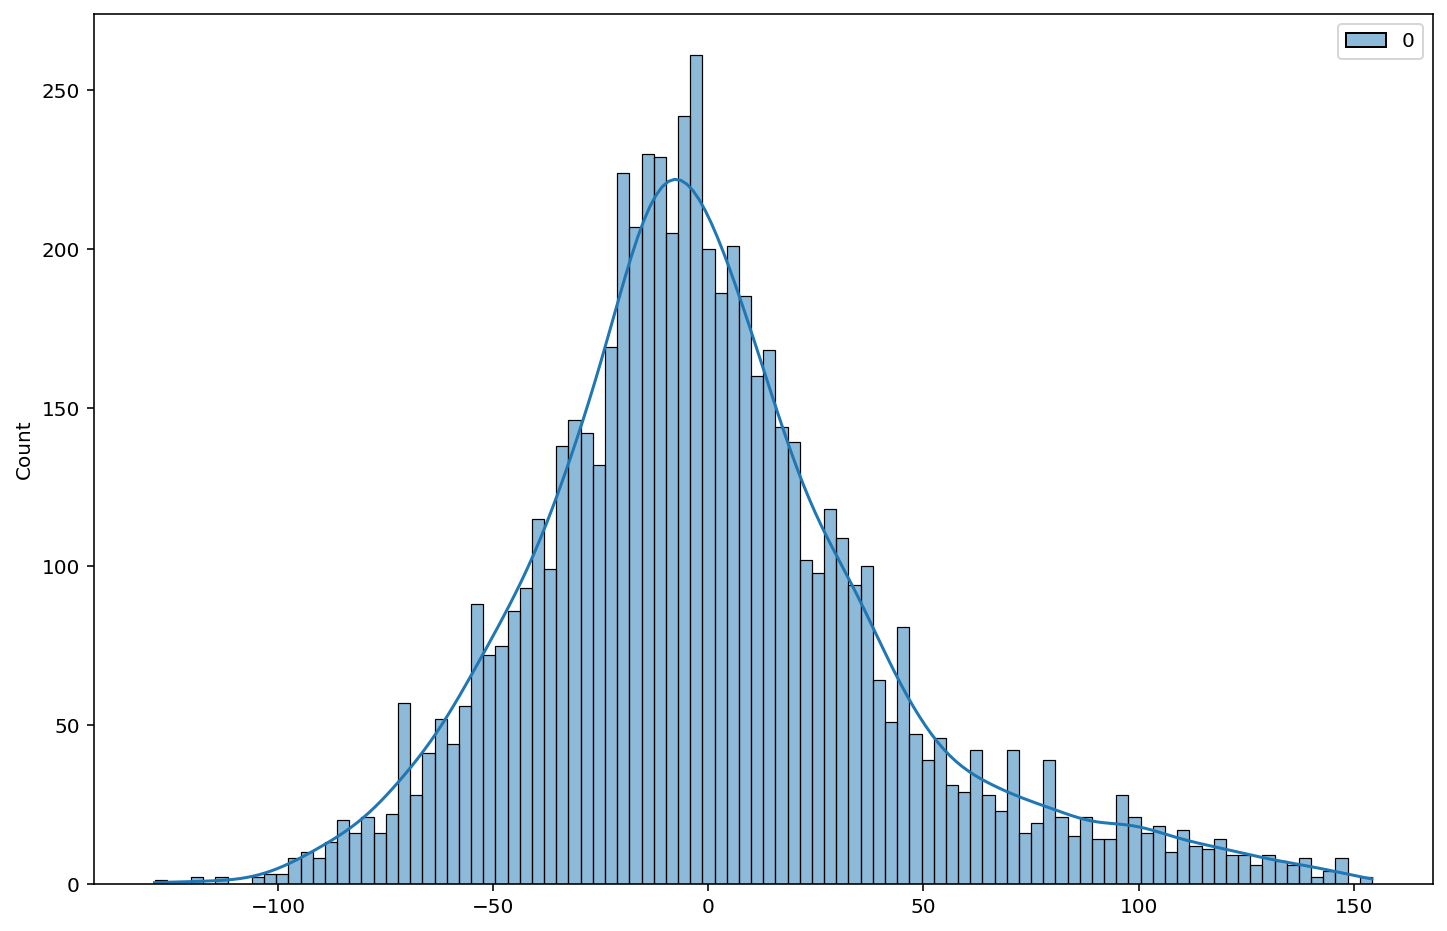

In [39]:
fig = plt.figure(figsize=(12,8))
sns.histplot(diff,bins=100, kde=True)

ใกล้เคียง norm dist นิดหน่อย และหนักซ้ายนิดนึง  
ผลต่างระหว่างค่าจริงกับค่าทำนาย ค่อนข้างจะอยู่ใกล้ 0

### เปรียบเทียบ ราคาจริงกับการทำนาย

In [40]:
dict_compare = {'Price': y_real.flatten(), 'predicted':  predicted.flatten()}
df_predicted = pd.DataFrame(dict_compare)

In [41]:
df_predicted.sample(5)

Price   predicted
4169  225.0  162.855631
3585   97.0   73.751200
4593  290.0  153.766526
2417   55.0   56.471428
5918   90.0  162.124621

In [42]:
#print(df_predicted.to_string())

In [43]:
df_predicted.corr()

Price  predicted
Price      1.000000   0.754905
predicted  0.754905   1.000000

correlation ระหว่าง test กับ predicted เท่ากับ 0.75 คือ ค่าไปด้วยกันพอสมควร

### ทดลองใช้โมเดลทำนาย

ต้องการทำนายว่า  
พักได้ 3 คน, มี 2 เตียง, ห้องน้ำ 2 ห้อง, ห้องน้ำ private, ย่าน Manhattan, ประเภทห้อง Entire home/apt น่าจะมีราคาค่าเช่าเท่าไร

สร้าง DataFrame เพื่อ feed เข้า model ให้ predict

In [44]:
tmp = pd.DataFrame([[3,2,2,0,0,1,0,0,0,0,0]], 
                   columns=df_real.drop(['price'], axis=1).columns)
tmp

accommodates  beds  baths  neighbourhood_group_cleansed_Brooklyn  \
0             3     2      2                                      0   

   neighbourhood_group_cleansed_Manhattan  \
0                                       0   

   neighbourhood_group_cleansed_Queens  \
0                                    1   

   neighbourhood_group_cleansed_Staten Island  room_type_Hotel room  \
0                                           0                     0   

   room_type_Private room  room_type_Shared room  shared-baths_1  
0                       0                      0               0

In [45]:
lm.predict(tmp)

array([[130.68371312]])

---
# 2. Support Vector Regression (SVR)
---

**SVR มีแนวคิดที่คล้ายกับ SVM**  

Kernel เป็นตัวดึงมิติ

Kernel Trick เป็นการดึง data points ให้อยู่ในมิติที่สูงขึ้น เพื่อแยกวัตถุออกจากกัน เช่น จากเดิมข้อมูลอยู่ใน 2 มิติ และไม่เป็น linearly separable พอดึงเป็น 3 มิติ ก็จะแยกข้อมูลออกจากกันได้ แล้วใช้ plane ในการ separate ได้

SVR ใช้ hyperplane ซึ่ง fit โดยพยายามให้ support vector อยู่บน boundary decision ให้มากที่สุด และพยายามลด errors (วัด errors จาก data points ที่อยู่นอก boundary decision) ให้น้อยที่สุด

> SVR คือจุดจะอยู่บน hyperplane มากที่สุดและที่เหลือจะอยู่ภายใน positive and negative hyperplanes และพยายามลดจุดที่อยู่นอก boundary decision ให้น้อยที่สุด  

> SVM จะสร้าง hyperplane โดยพยายามให้ negtive points อยู่ใต้ negative hyperplanes และ positive points อยู่เหนือ positive hyperplanes และพยายามให้ hyperplanes ทั้งสองห่างกันให้มากที่สุด

## Train-Test Split
ด้วย 80:20 ratio

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

In [47]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(25121, 11)
(6281, 11)
(25121, 1)
(6281, 1)


ควรจะทำ Data Scaling หลังจาก split แล้ว เพราะโมเดลไม่ควรรับรู้อะไรเกี่ยวกับ testing set ซึ่งจะอิงความเป็นจริงมากกว่า  

ถ้าทำ Data Scaling ก่อน จะเป็นการทำกับทั้ง dataset โมเดลอาจรับรู้ค่าสูงสุดต่ำสุดของ dataset นั้นด้วย จะเหมือนกับว่าเราใบ้โมเดลไปหน่อยนึงแล้ว จะทำให้เกิด bias ได้

### Data Scaling (Standardization)

ไม่ทำ Data Scaling กับ y  

เราทำ Data Scaling เพราะเราอยากให้มันมี scale ใกล้กัน ตอน fit model กับ X จะได้วัดระยะห่างของ data points ได้ง่าย ส่วน y เป็น target จึงไม่มีปัญหาด้าน scaling

In [48]:
from sklearn.preprocessing import StandardScaler

sc_X_train = StandardScaler()
sc_X_test = StandardScaler()

In [49]:
X_train = sc_X_train.fit_transform(X_train)
X_test = sc_X_test.fit_transform(X_test)

ใช้ Kernel แบบ Radial Basis Function (RBF)  
เพราะ RBF เป็นฟังก์ชั่นที่ช่วยให้ hyperplane เป็นเส้นโค้งได้  
สามารถจัดการข้อมูลตามโลกความจริงซึ่งเป็นแบบ non-linear ได้  

In [50]:
from sklearn.svm import SVR
svr_regressor = SVR(kernel='rbf')
svr_regressor.fit(X_train, y_train.ravel())

SVR()

## Model Evaluation

In [51]:
predicted = svr_regressor.predict(X_test)
predicted

array([ 86.64613893,  67.19077516, 164.89717152, ...,  67.19077516,
        66.83315787,  75.46329525])

In [52]:
print('MAE:', metrics.mean_absolute_error(y_test, predicted))
print('MSE:', metrics.mean_squared_error(y_test, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

MAE: 30.03076275279097
MSE: 1701.3728751633957
RMSE: 41.24770145309185


In [53]:
print('R2:', r2_score(y_test, predicted))

R2: 0.5638531029569036


In [54]:
# For use in the performance graph comparison at the end
RMSE_SVR = np.sqrt(metrics.mean_squared_error(y_test, predicted))
R2_SVR = r2_score(y_test, predicted)

### distribution plot ของผลต่างระหว่าง y_test กับ predicted

In [55]:
diff = y_test.ravel()-predicted.ravel()

<AxesSubplot:ylabel='Count'>

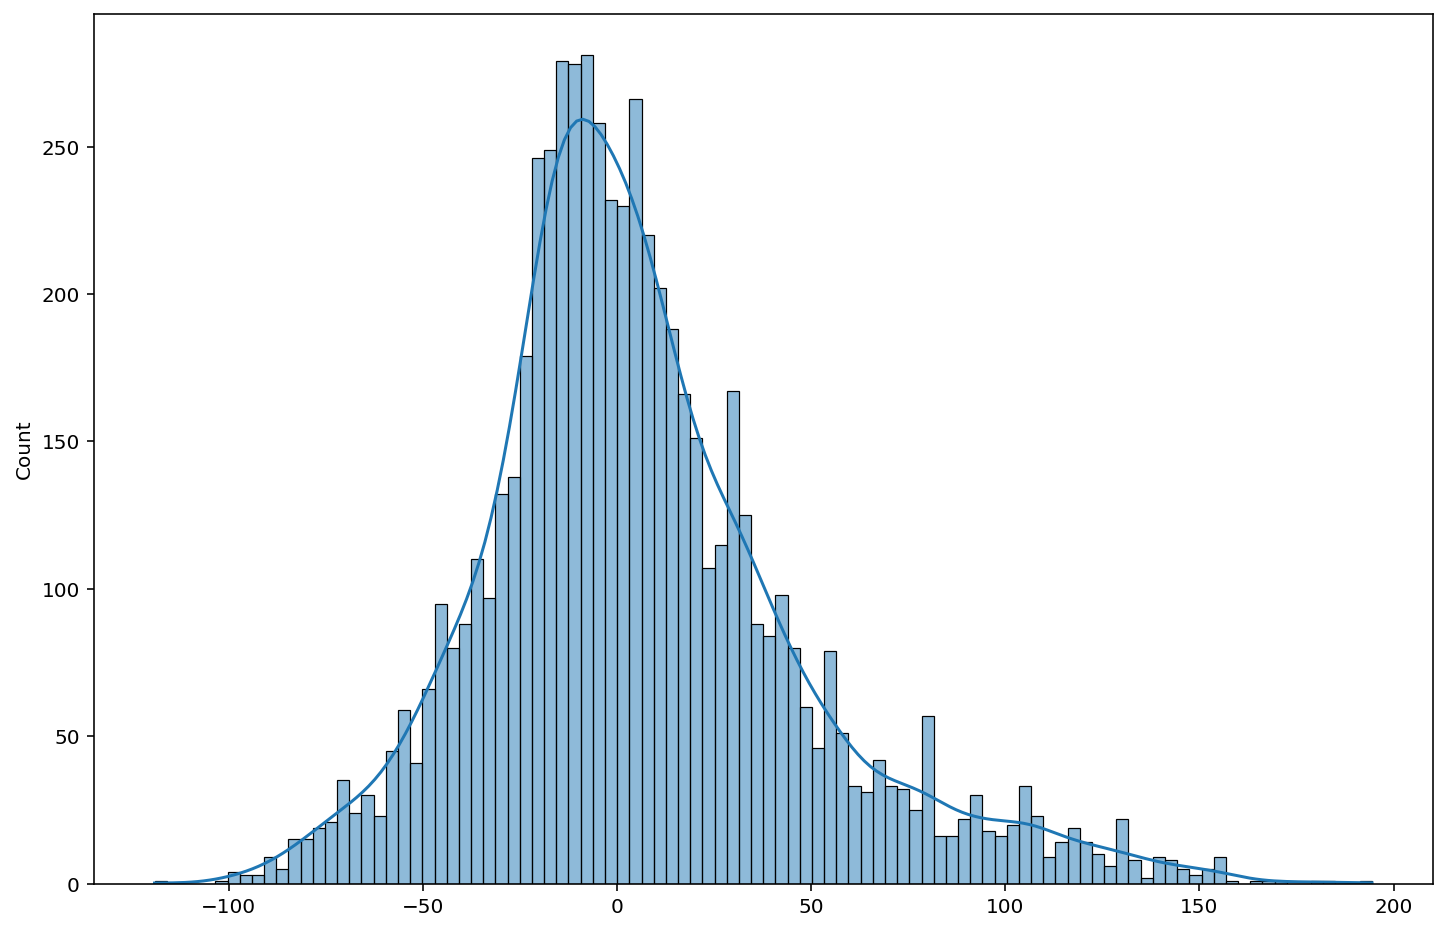

In [56]:
fig = plt.figure(figsize=(12,8))
sns.histplot(diff, bins=100, kde=True)

ใกล้เคียง norm dist นิดหน่อย และหนักซ้ายนิดนึง  
ผลต่างระหว่างค่าจริงกับค่าทำนาย ค่อนข้างจะอยู่ใกล้ 0

### เปรียบเทียบ ราคาจริงกับการทำนาย

In [57]:
dict_compare = {'Price': y_test.flatten(), 'predicted':  predicted.flatten()}
df_predicted = pd.DataFrame(dict_compare)

In [58]:
df_predicted.sample(5)

Price   predicted
3192   54.0   74.630906
5462   50.0   51.536747
2759  139.0  141.310054
3661   50.0   51.536747
2593   95.0   66.564060

In [59]:
#print(df_predicted.to_string())

In [60]:
df_predicted.corr()

Price  predicted
Price      1.000000   0.759284
predicted  0.759284   1.000000

correlation ระหว่าง test กับ predicted เท่ากับ 0.76 คือ ค่าไปด้วยกันพอสมควร

### ทดลองใช้โมเดลทำนาย

ต้องการทำนายว่า  
พักได้ 3 คน, มี 2 เตียง, ห้องน้ำ 2 ห้อง, ห้องน้ำ private, ย่าน Manhattan, ประเภทห้อง Entire home/apt น่าจะมีราคาค่าเช่าเท่าไร

สร้าง DataFrame เพื่อ feed เข้า model ให้ predict

In [61]:
tmp = pd.DataFrame([[3,2,2,0,0,1,0,0,0,0,0]], 
                   columns=df_real.drop(['price'], axis=1).columns)
tmp

accommodates  beds  baths  neighbourhood_group_cleansed_Brooklyn  \
0             3     2      2                                      0   

   neighbourhood_group_cleansed_Manhattan  \
0                                       0   

   neighbourhood_group_cleansed_Queens  \
0                                    1   

   neighbourhood_group_cleansed_Staten Island  room_type_Hotel room  \
0                                           0                     0   

   room_type_Private room  room_type_Shared room  shared-baths_1  
0                       0                      0               0

In [62]:
svr_regressor.predict(tmp)

array([165.52144199])

---
# 3. Performance Graph Comparison
---

Text(0.5, 1.0, 'R2 (more is better)')

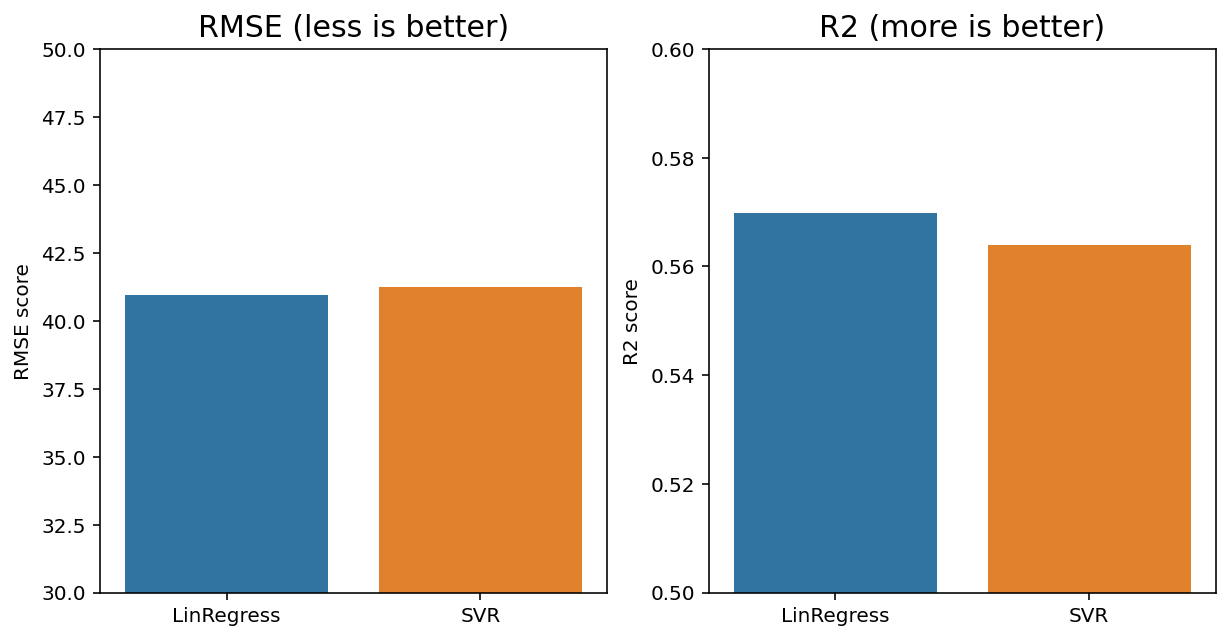

In [63]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

sns.barplot(x = ['LinRegress','SVR'],
            y = [RMSE_LR, RMSE_SVR], ax=ax[0])
ax[0].set(ylabel='RMSE score', ylim=(30,50))
ax[0].set_title('RMSE (less is better)', fontsize=15)

sns.barplot(x = ['LinRegress','SVR'],
            y = [R2_LR, R2_SVR], ax=ax[1])
ax[1].set(ylabel='R2 score', ylim=(0.5,0.6))
ax[1].set_title('R2 (more is better)', fontsize=15)

---
# Thank You